In [1]:
import os
import pandas as pd
import scanpy as sc
import numpy as np
import jax.tree_util as jtu
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import issparse
from scipy.stats import pearsonr, spearmanr
from collections import defaultdict
from utils import calc_zscores, plot_heatmaps_by_knockout_ordered, filter_deg_optimized, calculate_similarities
from functools import partial

cmap = sns.color_palette("coolwarm", as_cmap=True)
cell_line_order = ['HAP1', 'K562', 'A549', 'HT29', 'MCF7','Mean', 'BXPC3', 'BXPC3 (predicted)']

In [2]:
def calc_zscores_limited_nr_cells(sample1, sample2, limit_sample_1, limit_sample_2):
    if issparse(sample1):
        sample1 = sample1.toarray()
    if issparse(sample2):
        sample2 = sample2.toarray()

    # limit_sample_1 = np.min(limit_sample_1, sample1.shape[0])
    # limit_sample_2 = np.min(limit_sample_2, sample2.shape[0])
    sample1 = sample1[limit_sample_1,:]
    sample2 = sample2[limit_sample_2,:]

    mean1 = sample1.mean(axis=0)
    std1 = sample1.std(axis=0)
    mean2 = sample2.mean(axis=0)
    std2 = sample2.std(axis=0)
    
    n1 = sample1.shape[0]
    n2 = sample2.shape[0]
    se = np.sqrt((std1**2 / n1) + (std2**2 / n2))
    
    z_scores = (mean1 - mean2) / se
    return z_scores

In [3]:
predictions_path = '/lustre/groups/ml01/workspace/alessandro.palma/ot_pert/out/results_metrics/generated_data/sweep_cell_line_pathway/adata_ood_split_BXPC3_IFNG.h5ad'
train_path = '/lustre/groups/ml01/workspace/ot_perturbation/data/satija/datasets/adata_ood_final_pathway_cell_type/BXPC3_IFNG/adata_train_BXPC3_IFNG.h5ad'
test_path = '/lustre/groups/ml01/workspace/ot_perturbation/data/satija/datasets/adata_ood_final_pathway_cell_type/BXPC3_IFNG/adata_test_BXPC3_IFNG.h5ad'
ood_path = '/lustre/groups/ml01/workspace/ot_perturbation/data/satija/datasets/adata_ood_final_pathway_cell_type_full_source/BXPC3_IFNG/adata_ood_BXPC3_IFNG.h5ad'

In [4]:
predictions = sc.read_h5ad(predictions_path)
train = sc.read_h5ad(train_path)
test = sc.read_h5ad(test_path)
ood = sc.read_h5ad(ood_path)

# generate dicts for jtu tree_map
ood_target = ood[ood.obs['gene'] != 'NT', :]
ood_source = ood[ood.obs['gene'] == 'NT', :]
ood_target_dict = {c: ood_target[ood_target.obs['condition'] == c, :].X for c in ood_target.obs['condition'].unique()}
ood_source_dict = {c: ood_source[ood_source.obs['pathway'] == c.split('_')[1], :].X for c in ood_target.obs['condition'].unique()}
ood_prediction = {c: predictions[predictions.obs['condition'] == c].layers['X_recon_pred'] for c in predictions.obs['condition'].unique()}

train = ad.concat([train, test])
train_target = train[train.obs['gene'] != 'NT', :]
train_source = train[train.obs['gene'] == 'NT', :]
train_target_dict = {c: train_target[train_target.obs['condition'] == c, :].X for c in train_target.obs['condition'].unique()}
train_source_dict = {c: train_source[train_source.obs['pathway'] == c.split('_')[1], :].X for c in train_target.obs['condition'].unique()}

In [5]:
ood_zscores = jtu.tree_map(calc_zscores, ood_target_dict, ood_source_dict)
prediction_zscores = jtu.tree_map(calc_zscores, ood_prediction, ood_source_dict)
train_zscores = jtu.tree_map(calc_zscores, train_target_dict, train_source_dict)

/ictstr01/home/icb/lea.zimmermann/projects/ot_pert_reproducibility/evaluation/evaluate_downstream/utils.py:28: RuntimeWarning: invalid value encountered in divide
  z_scores = (mean1 - mean2) / se


In [8]:
df_train = []
for key, value in train_zscores.items():
    df_train.append(pd.DataFrame({
        'predicted': False,
        'cell_line': key.split('_')[0],
        'pathway': key.split('_')[1],
        'knockout': key.split('_')[2],
        'gene': list(train.var_names),
        'zscore': value
    }))
df_train = pd.concat(df_train)

df_ood = []
for key, value in ood_zscores.items():
    df_ood.append(pd.DataFrame({
        'predicted': False,
        'cell_line': key.split('_')[0],
        'pathway': key.split('_')[1],
        'knockout': key.split('_')[2],
        'gene': list(ood.var_names),
        'zscore': value
    }))
df_ood = pd.concat(df_ood)

df_prediction = []
for key, value in prediction_zscores.items():
    df_prediction.append(pd.DataFrame({
        'predicted': True,
        'cell_line': key.split('_')[0] + ' (predicted)',
        'pathway': key.split('_')[1],
        'knockout': key.split('_')[2],
        'gene': list(ood.var_names),
        'zscore': value
    }))
df_predicted = pd.concat(df_prediction)
df_predicted_filtered = df_predicted[df_predicted['zscore'].notna()]

df_ground_truth = pd.concat([df_train, df_ood])
df_ground_truth_filtered = df_ground_truth[df_ground_truth['zscore'].notna()]

df_zscores = pd.concat([df_ground_truth, df_predicted])

In [9]:
perturbation_programs = pd.read_csv('./table3_programs.csv')

In [10]:
present_in_BXPC3 = perturbation_programs.query('cellline == "BXPC3" and pathway == "IFNG"')[['pathway', 'program', 'gene', 'perturbation']].drop_duplicates()
valid_combinations = set(zip(present_in_BXPC3['gene'], present_in_BXPC3['perturbation'], present_in_BXPC3['pathway'], present_in_BXPC3['program']))

filtered_df = perturbation_programs[
    perturbation_programs[['gene', 'perturbation', 'pathway', 'program']].apply(tuple, axis=1).isin(valid_combinations)
]

cell_line_counts = (
    filtered_df.groupby(['gene', 'pathway', 'perturbation', 'program'])['cellline']
    .nunique()
    .reset_index(name='cellline_count')
)

valid_combinations = cell_line_counts[cell_line_counts['cellline_count'] >= 6] # TODO: should we choose another threshold?

df_present_in_all_ct = filtered_df.merge(valid_combinations[['gene', 'pathway', 'perturbation', 'program']], 
                                on=['gene', 'pathway', 'perturbation', 'program'], 
                                how='inner')
df_present_in_all_ct = df_present_in_all_ct.drop(columns=['Unnamed: 0'])

In [11]:
df_present_in_all_ct['program'].value_counts()

program
IFNG_program1_up      9000
IFNG_program1_down    9000
Name: count, dtype: int64

## program 1

In [12]:
IFNG_program1 = df_present_in_all_ct.query('program =="IFNG_program1_up" or program == "IFNG_program1_down"')
IFNG_program1 = IFNG_program1.rename(columns={'perturbation': 'knockout'}).drop(columns=['cellline'])
df_selected = df_zscores.merge(IFNG_program1, on=['pathway', 'gene', 'knockout'], how='inner').drop_duplicates()

In [13]:
df_selected_train = df_selected[~df_selected['cell_line'].str.contains('BXPC3')]
df_selected_train

,predicted,cell_line,pathway,knockout,gene,zscore,program
0,False,A549,IFNG,IFNGR1,ABCC3,13.510861,IFNG_program1_up
6,False,A549,IFNG,IFNGR1,ABLIM1,-0.555422,IFNG_program1_up
12,False,A549,IFNG,IFNGR1,ABLIM3,-1.288935,IFNG_program1_up
18,False,A549,IFNG,IFNGR1,AC004784.1,2.921746,IFNG_program1_up
24,False,A549,IFNG,IFNGR1,AC005515.1,-23.818016,IFNG_program1_down
...,...,...,...,...,...,...,...
30330,False,MCF7,IFNG,JAK2,XACT,-20.574600,IFNG_program1_up
30336,False,MCF7,IFNG,JAK2,XRN1,-16.540094,IFNG_program1_down
30342,False,MCF7,IFNG,JAK2,ZC3HAV1,-31.493265,IFNG_program1_down
30348,False,MCF7,IFNG,JAK2,ZNF704,20.258299,IFNG_program1_up


In [14]:
df_mean_zscore = df_selected_train.groupby(['knockout', 'gene', 'program'])['zscore'].mean().reset_index()
df_mean_zscore['cell_line'] = 'Mean'
df_mean_zscore['predicted'] = True
df_mean_zscore['pathway'] = 'IFNG'
df_mean_zscore

,knockout,gene,program,zscore,cell_line,predicted,pathway
0,IFNGR1,ABCC3,IFNG_program1_up,-10.294456,Mean,True,IFNG
1,IFNGR1,ABLIM1,IFNG_program1_up,-3.805677,Mean,True,IFNG
2,IFNGR1,ABLIM3,IFNG_program1_up,0.075091,Mean,True,IFNG
3,IFNGR1,AC004784.1,IFNG_program1_up,0.458993,Mean,True,IFNG
4,IFNGR1,AC005515.1,IFNG_program1_down,-31.512077,Mean,True,IFNG
...,...,...,...,...,...,...,...
1095,STAT1,XACT,IFNG_program1_up,-3.965842,Mean,True,IFNG
1096,STAT1,XRN1,IFNG_program1_down,-13.558362,Mean,True,IFNG
1097,STAT1,ZC3HAV1,IFNG_program1_down,-18.677998,Mean,True,IFNG
1098,STAT1,ZNF704,IFNG_program1_up,-13.331358,Mean,True,IFNG


In [15]:
df_selected = pd.concat([df_mean_zscore, df_selected])

/ictstr01/home/icb/lea.zimmermann/projects/ot_pert_reproducibility/evaluation/evaluate_downstream/utils.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


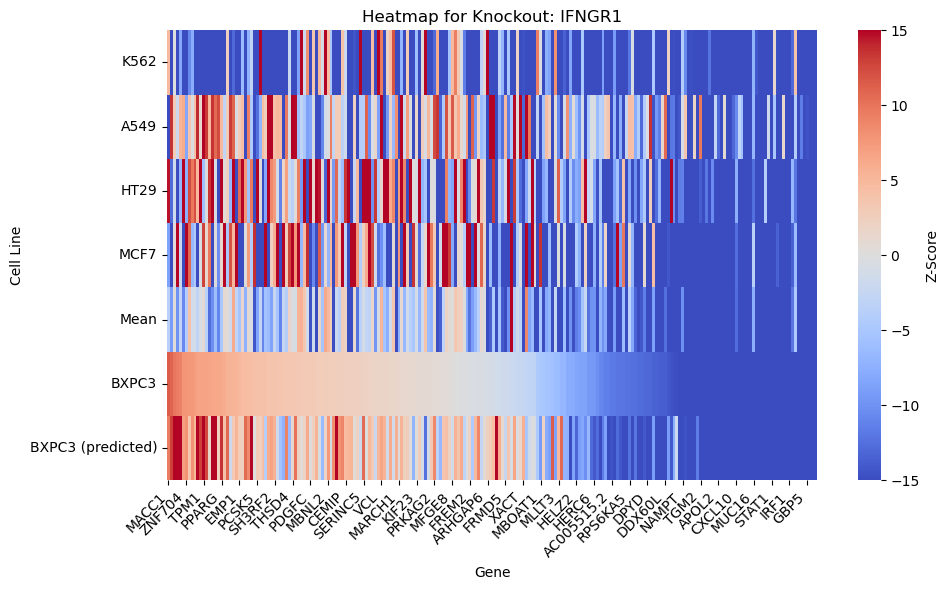

/ictstr01/home/icb/lea.zimmermann/projects/ot_pert_reproducibility/evaluation/evaluate_downstream/utils.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


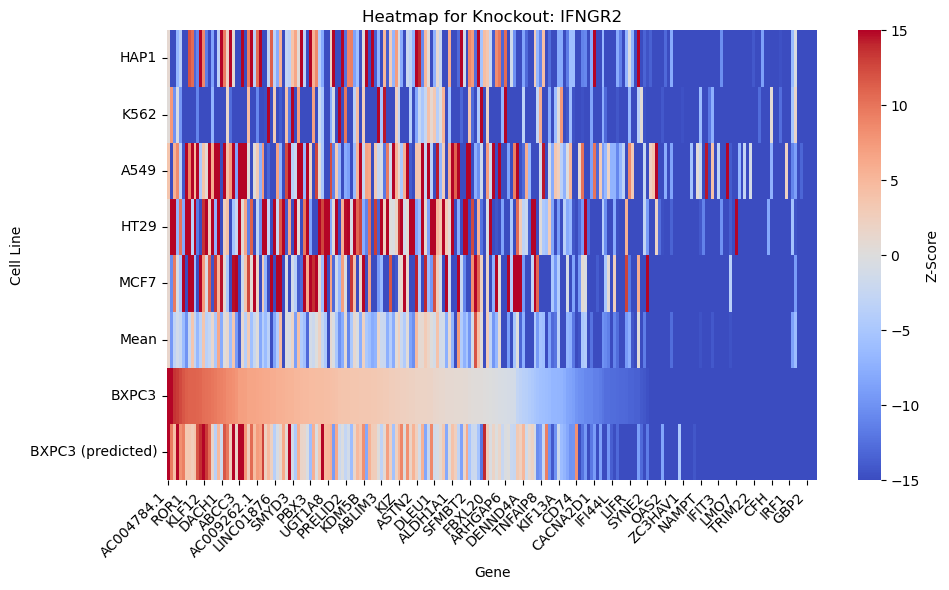

/ictstr01/home/icb/lea.zimmermann/projects/ot_pert_reproducibility/evaluation/evaluate_downstream/utils.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


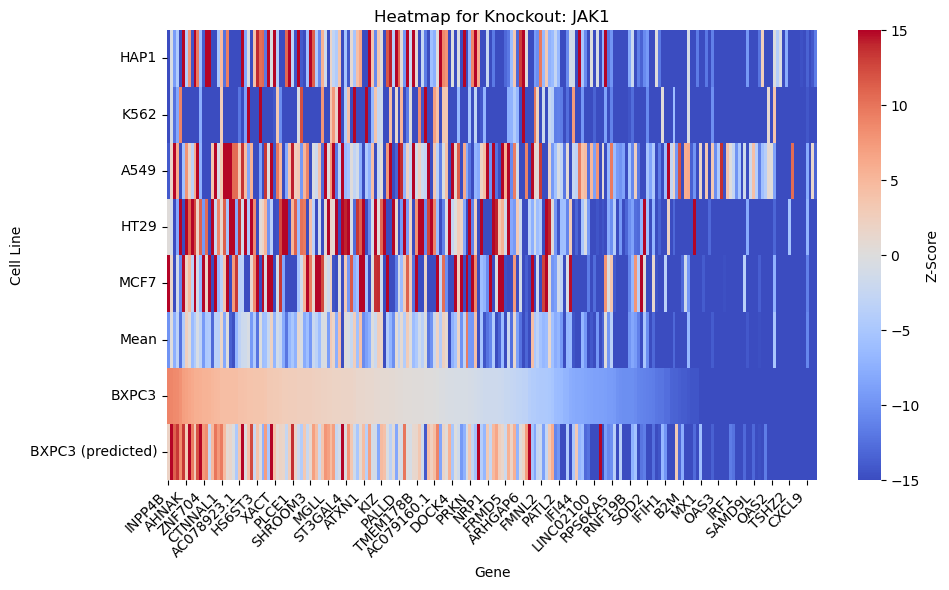

/ictstr01/home/icb/lea.zimmermann/projects/ot_pert_reproducibility/evaluation/evaluate_downstream/utils.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


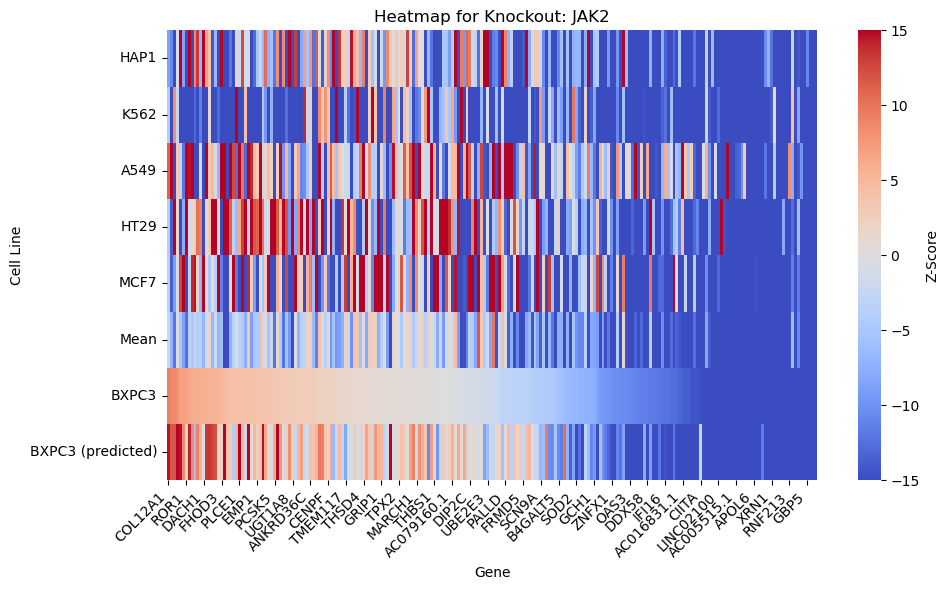

/ictstr01/home/icb/lea.zimmermann/projects/ot_pert_reproducibility/evaluation/evaluate_downstream/utils.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


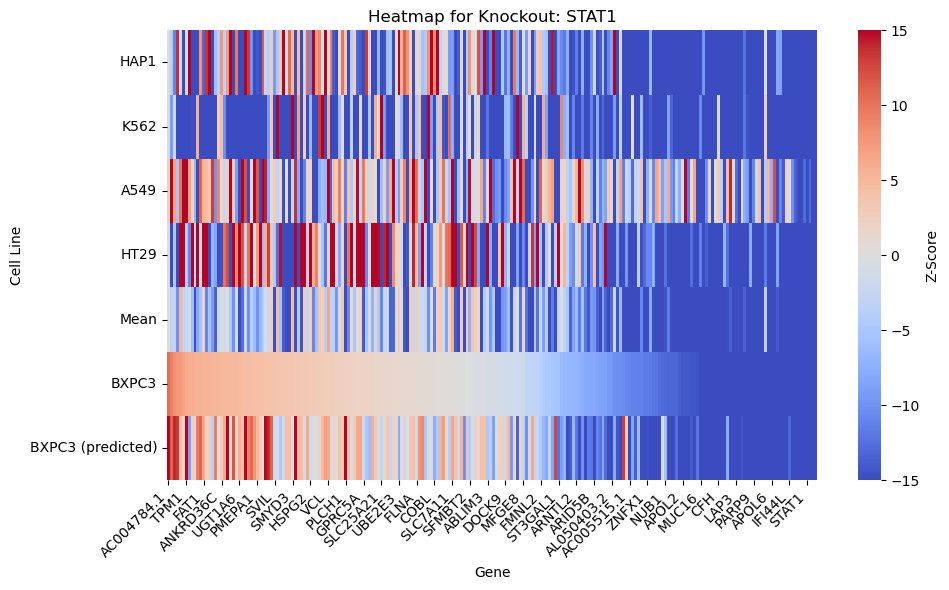

In [27]:
plot_heatmaps_by_knockout_ordered(df_selected, vmin=-15, vmax=15, cell_line_order=cell_line_order)

In [202]:
df_selected = df_selected.drop(columns=['cell_line', 'zscore', 'program'])
df_predicted_heatmaps = df_predicted_filtered.merge(df_selected, on=['pathway', 'gene', 'knockout'], how='inner')
df_ground_truth_heatmaps = df_ground_truth_filtered.merge(df_selected, on=['pathway', 'gene', 'knockout'], how='inner')

df_results_heatmaps = calculate_similarities(df_predicted_heatmaps, df_ground_truth_heatmaps)
df_results_heatmaps

,cell_line_predicted,cell_line,pearson_correlation,spearman_correlation,MAE
0,BXPC3 (predicted),A549,0.359019,0.349592,14.919915
1,BXPC3 (predicted),HAP1,0.390602,0.397691,16.856281
2,BXPC3 (predicted),HT29,0.489989,0.558404,14.997198
3,BXPC3 (predicted),K562,0.222574,0.170841,23.490984
4,BXPC3 (predicted),MCF7,0.412167,0.423035,18.532595
5,BXPC3 (predicted),BXPC3,0.889099,0.840050,6.658049


In [29]:
df_selected_pred = df_selected[df_selected['predicted']]
df_selected_gt = df_selected[df_selected['predicted']==False]

df_results_heatmaps = calculate_similarities(df_selected_pred, df_selected_gt)
df_results_heatmaps

,cell_line_predicted,cell_line,pearson_correlation,spearman_correlation,MAE
0,Mean,A549,0.509258,0.464374,12.819393
1,Mean,HAP1,0.720694,0.679735,11.264742
2,Mean,HT29,0.590023,0.568276,12.672118
3,Mean,K562,0.643264,0.608212,16.172583
4,Mean,MCF7,0.657444,0.680932,13.392938
5,Mean,BXPC3,0.743324,0.689128,8.441284
6,BXPC3 (predicted),A549,0.356682,0.346787,14.862349
7,BXPC3 (predicted),HAP1,0.393697,0.401893,16.871572
8,BXPC3 (predicted),HT29,0.489304,0.557631,14.975746
9,BXPC3 (predicted),K562,0.223669,0.171225,23.496279


In [17]:
df_selected

,knockout,gene,program,zscore,cell_line,predicted,pathway
0,IFNGR1,ABCC3,IFNG_program1_up,-10.294456,Mean,True,IFNG
1,IFNGR1,ABLIM1,IFNG_program1_up,-3.805677,Mean,True,IFNG
2,IFNGR1,ABLIM3,IFNG_program1_up,0.075091,Mean,True,IFNG
3,IFNGR1,AC004784.1,IFNG_program1_up,0.458993,Mean,True,IFNG
4,IFNGR1,AC005515.1,IFNG_program1_down,-31.512077,Mean,True,IFNG
...,...,...,...,...,...,...,...
43530,STAT1,XACT,IFNG_program1_up,4.047960,BXPC3 (predicted),True,IFNG
43536,STAT1,XRN1,IFNG_program1_down,-15.453507,BXPC3 (predicted),True,IFNG
43542,STAT1,ZC3HAV1,IFNG_program1_down,-15.868315,BXPC3 (predicted),True,IFNG
43548,STAT1,ZNF704,IFNG_program1_up,9.390550,BXPC3 (predicted),True,IFNG


In [18]:
df_selected_IFNGR1 = df_selected.query('knockout == "IFNGR1"')
df_selected_IFNGR2 = df_selected.query('knockout == "IFNGR2"')
df_selected_JAK1 = df_selected.query('knockout == "JAK1"')

In [19]:
df_selected_IFNGR1_pred = df_selected_IFNGR1[df_selected_IFNGR1['predicted']]
df_selected_IFNGR1_gt = df_selected_IFNGR1[df_selected_IFNGR1['predicted']==False]

df_results_heatmaps = calculate_similarities(df_selected_IFNGR1_pred, df_selected_IFNGR1_gt)
df_results_heatmaps

,cell_line_predicted,cell_line,pearson_correlation,spearman_correlation,MAE
0,Mean,A549,0.606024,0.527756,11.049040
1,Mean,HT29,0.622230,0.612612,11.468022
2,Mean,K562,0.627580,0.587406,15.942612
3,Mean,MCF7,0.716947,0.718954,12.709106
4,Mean,BXPC3,0.744266,0.691616,8.239872
5,BXPC3 (predicted),A549,0.423540,0.404581,13.604263
6,BXPC3 (predicted),HT29,0.491800,0.550295,14.191824
7,BXPC3 (predicted),K562,0.223599,0.161109,23.655153
8,BXPC3 (predicted),MCF7,0.457081,0.468460,17.844790
9,BXPC3 (predicted),BXPC3,0.910584,0.850175,6.376186


In [20]:
df_selected_IFNGR2_pred = df_selected_IFNGR2[df_selected_IFNGR2['predicted']]
df_selected_IFNGR2_gt = df_selected_IFNGR2[df_selected_IFNGR2['predicted']==False]

df_results_heatmaps = calculate_similarities(df_selected_IFNGR2_pred, df_selected_IFNGR2_gt)
df_results_heatmaps

,cell_line_predicted,cell_line,pearson_correlation,spearman_correlation,MAE
0,Mean,A549,0.591724,0.556196,13.519447
1,Mean,HAP1,0.763382,0.715677,11.391295
2,Mean,HT29,0.621727,0.585742,13.941635
3,Mean,K562,0.602389,0.544483,15.070310
4,Mean,MCF7,0.710786,0.731378,13.616107
5,Mean,BXPC3,0.790610,0.736586,9.418109
6,BXPC3 (predicted),A549,0.436211,0.426729,15.702168
7,BXPC3 (predicted),HAP1,0.472284,0.446979,17.452295
8,BXPC3 (predicted),HT29,0.531678,0.600276,15.970989
9,BXPC3 (predicted),K562,0.268194,0.193088,22.077600


In [21]:
df_selected_JAK1_pred = df_selected_JAK1[df_selected_JAK1['predicted']]
df_selected_JAK1_gt = df_selected_JAK1[df_selected_JAK1['predicted']==False]

df_results_heatmaps = calculate_similarities(df_selected_JAK1_pred, df_selected_JAK1_gt)
df_results_heatmaps

,cell_line_predicted,cell_line,pearson_correlation,spearman_correlation,MAE
0,Mean,A549,0.368410,0.371164,12.996042
1,Mean,HAP1,0.603024,0.616948,11.675963
2,Mean,HT29,0.466720,0.475419,12.756461
3,Mean,K562,0.619449,0.606613,17.965193
4,Mean,MCF7,0.570214,0.618370,13.490829
5,Mean,BXPC3,0.716195,0.679698,7.592977
6,BXPC3 (predicted),A549,0.249077,0.266362,14.860106
7,BXPC3 (predicted),HAP1,0.235386,0.274195,17.240509
8,BXPC3 (predicted),HT29,0.445179,0.526982,14.640178
9,BXPC3 (predicted),K562,0.186899,0.150001,24.726084


## program 2

In [89]:
program2 = perturbation_programs.query('program =="IFNG_program2_up" or program == "IFNG_program2_down"')[['pathway', 'program', 'gene', 'perturbation']].drop_duplicates()
valid_combinations = set(zip(program2['gene'], program2['perturbation'], program2['pathway'], program2['program']))

program2_df = perturbation_programs[
    perturbation_programs[['gene', 'perturbation', 'pathway', 'program']].apply(tuple, axis=1).isin(valid_combinations)
]

In [90]:
program2_df

,Unnamed: 0,pathway,program,gene,cellline,perturbation
51914,2,IFNG,IFNG_program2_up,CFH,A549,IRF1
51915,2,IFNG,IFNG_program2_up,CXCL9,A549,IRF1
51916,2,IFNG,IFNG_program2_up,THBS1,A549,IRF1
51917,2,IFNG,IFNG_program2_up,DENND4A,A549,IRF1
51918,2,IFNG,IFNG_program2_up,ST5,A549,IRF1
...,...,...,...,...,...,...
53201,3,IFNG,IFNG_program2_down,ANKRD18B,HT29,IRF1
53202,3,IFNG,IFNG_program2_down,CADPS2,HT29,IRF1
53203,3,IFNG,IFNG_program2_down,GBP5,HT29,IRF1
53204,3,IFNG,IFNG_program2_down,NTN4,HT29,IRF1


In [91]:
program2_df = program2_df.rename(columns={'perturbation': 'knockout'}).drop(columns=['cellline', 'Unnamed: 0', 'program'])
df_selected = df_zscores.merge(program2_df, on=['pathway', 'gene', 'knockout'], how='inner').drop_duplicates()

In [92]:
df_selected['cell_line_orig'] = df_selected['cell_line']
df_selected['cell_line'] = df_selected['cell_line'] + ' (' + df_selected['knockout'] + ')'
df_selected['knockout'] = 'IFNG program 2'

In [93]:
df_selected_train = df_selected[~df_selected['cell_line'].str.contains('BXPC3')]
df_selected_train

,predicted,cell_line,pathway,knockout,gene,zscore,cell_line_orig
0,False,A549 (IRF1),IFNG,IFNG program 2,ABCC3,15.182554,A549
3,False,A549 (IRF1),IFNG,IFNG program 2,AC005515.1,3.822694,A549
6,False,A549 (IRF1),IFNG,IFNG program 2,AC005515.2,4.145197,A549
9,False,A549 (IRF1),IFNG,IFNG program 2,AC016831.1,22.745880,A549
12,False,A549 (IRF1),IFNG,IFNG program 2,AC099520.1,-10.305631,A549
...,...,...,...,...,...,...,...
1953,False,MCF7 (IRF1),IFNG,IFNG program 2,WARS,-36.639881,MCF7
1956,False,MCF7 (IRF1),IFNG,IFNG program 2,XRN1,-13.343327,MCF7
1959,False,MCF7 (IRF1),IFNG,IFNG program 2,ZC3HAV1,-34.566963,MCF7
1962,False,MCF7 (IRF1),IFNG,IFNG program 2,ZFP36L1,-2.093766,MCF7


In [94]:
df_mean_zscore = df_selected_train.groupby(['knockout', 'gene'])['zscore'].mean().reset_index()
df_mean_zscore['cell_line'] = 'Mean (IRF1)'
df_mean_zscore['cell_line_orig'] = 'Mean'
df_mean_zscore['predicted'] = True
df_mean_zscore['pathway'] = 'IFNG'
df_mean_zscore

,knockout,gene,zscore,cell_line,cell_line_orig,predicted,pathway
0,IFNG program 2,ABCC3,-14.812412,Mean (IRF1),Mean,True,IFNG
1,IFNG program 2,AC005515.1,-17.628111,Mean (IRF1),Mean,True,IFNG
2,IFNG program 2,AC005515.2,-15.640966,Mean (IRF1),Mean,True,IFNG
3,IFNG program 2,AC016831.1,-13.228501,Mean (IRF1),Mean,True,IFNG
4,IFNG program 2,AC099520.1,-14.414729,Mean (IRF1),Mean,True,IFNG
...,...,...,...,...,...,...,...
159,IFNG program 2,WARS,-7.388966,Mean (IRF1),Mean,True,IFNG
160,IFNG program 2,XRN1,-4.964907,Mean (IRF1),Mean,True,IFNG
161,IFNG program 2,ZC3HAV1,-8.045498,Mean (IRF1),Mean,True,IFNG
162,IFNG program 2,ZFP36L1,-3.820950,Mean (IRF1),Mean,True,IFNG


In [95]:
df_selected = pd.concat([df_selected, df_mean_zscore])

In [96]:
df_selected

,predicted,cell_line,pathway,knockout,gene,zscore,cell_line_orig
0,False,A549 (IRF1),IFNG,IFNG program 2,ABCC3,15.182554,A549
3,False,A549 (IRF1),IFNG,IFNG program 2,AC005515.1,3.822694,A549
6,False,A549 (IRF1),IFNG,IFNG program 2,AC005515.2,4.145197,A549
9,False,A549 (IRF1),IFNG,IFNG program 2,AC016831.1,22.745880,A549
12,False,A549 (IRF1),IFNG,IFNG program 2,AC099520.1,-10.305631,A549
...,...,...,...,...,...,...,...
159,True,Mean (IRF1),IFNG,IFNG program 2,WARS,-7.388966,Mean
160,True,Mean (IRF1),IFNG,IFNG program 2,XRN1,-4.964907,Mean
161,True,Mean (IRF1),IFNG,IFNG program 2,ZC3HAV1,-8.045498,Mean
162,True,Mean (IRF1),IFNG,IFNG program 2,ZFP36L1,-3.820950,Mean


In [97]:
df_selected['cell_line'].unique()

array(['A549 (IRF1)', 'HAP1 (IRF1)', 'HT29 (IRF1)', 'MCF7 (IRF1)',
       'BXPC3 (IRF1)', 'BXPC3 (IRF2)', 'BXPC3 (predicted) (IRF1)',
       'BXPC3 (predicted) (IRF2)', 'Mean (IRF1)'], dtype=object)

In [98]:
cell_line_order = ['A549 (IRF1)', 'HAP1 (IRF1)', 'HT29 (IRF1)', 'MCF7 (IRF1)', 'Mean (IRF1)',
        'BXPC3 (IRF2)', 'BXPC3 (predicted) (IRF2)']

vmin=-15
vmax=15

In [99]:
df = df_selected
df = df[df['cell_line'].isin(cell_line_order)]
df['cell_line'].unique()

array(['A549 (IRF1)', 'HAP1 (IRF1)', 'HT29 (IRF1)', 'MCF7 (IRF1)',
       'BXPC3 (IRF2)', 'BXPC3 (predicted) (IRF2)', 'Mean (IRF1)'],
      dtype=object)

In [100]:
df

,predicted,cell_line,pathway,knockout,gene,zscore,cell_line_orig
0,False,A549 (IRF1),IFNG,IFNG program 2,ABCC3,15.182554,A549
3,False,A549 (IRF1),IFNG,IFNG program 2,AC005515.1,3.822694,A549
6,False,A549 (IRF1),IFNG,IFNG program 2,AC005515.2,4.145197,A549
9,False,A549 (IRF1),IFNG,IFNG program 2,AC016831.1,22.745880,A549
12,False,A549 (IRF1),IFNG,IFNG program 2,AC099520.1,-10.305631,A549
...,...,...,...,...,...,...,...
159,True,Mean (IRF1),IFNG,IFNG program 2,WARS,-7.388966,Mean
160,True,Mean (IRF1),IFNG,IFNG program 2,XRN1,-4.964907,Mean
161,True,Mean (IRF1),IFNG,IFNG program 2,ZC3HAV1,-8.045498,Mean
162,True,Mean (IRF1),IFNG,IFNG program 2,ZFP36L1,-3.820950,Mean


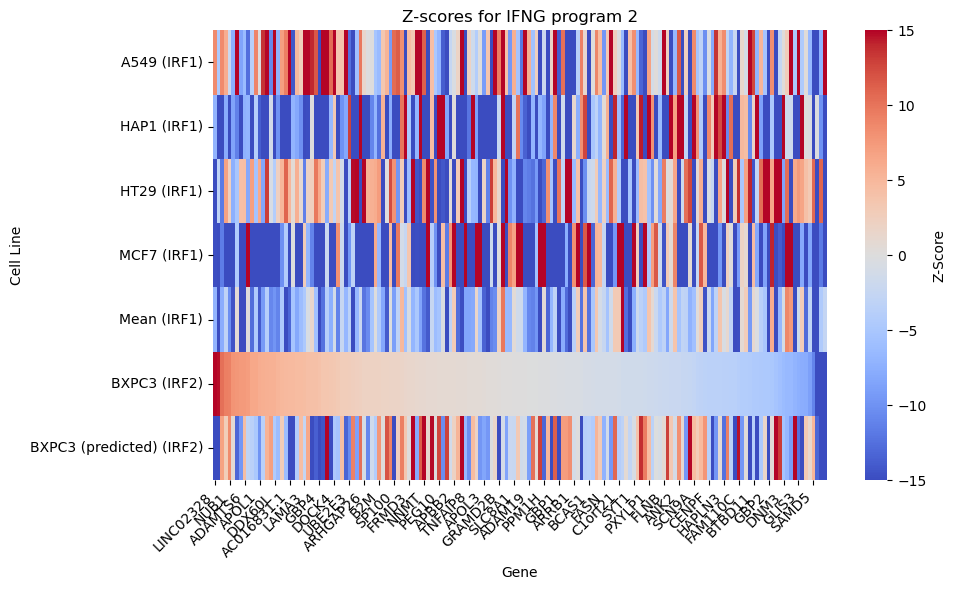

In [101]:
knockouts = df['knockout'].unique()
for knockout in knockouts:
    knockout_df = df[df['knockout'] == knockout]

    # Order cell lines
    if cell_line_order is not None:
        knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)
        knockout_df = knockout_df.sort_values('cell_line')
    
    # Determine gene order by z-scores in the BXPC3 cell line
    bxpc3_genes = knockout_df[knockout_df['cell_line'] == 'BXPC3 (IRF2)'][['gene', 'zscore']].dropna()
    gene_order = bxpc3_genes.sort_values('zscore', ascending=False)['gene'].tolist()

    # Pivot the data
    heatmap_data = knockout_df.pivot(index='cell_line', columns='gene', values='zscore')

    # Reorder the columns (genes) by BXPC3 z-scores
    heatmap_data = heatmap_data[gene_order]

    # Plot heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(
        heatmap_data,
        cmap='coolwarm',
        vmin=vmin,
        vmax=vmax,
        cbar_kws={'label': 'Z-Score'}
    )
    plt.title(f"Z-scores for {knockout}")
    plt.xlabel("Gene")
    plt.ylabel("Cell Line")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [102]:
df_selected['cell_line'] = df_selected['cell_line_orig']

In [103]:
df_selected_pred = df_selected[df_selected['predicted']]
df_selected_gt = df_selected[df_selected['predicted']==False]

In [104]:
df_results_heatmaps = calculate_similarities(df_selected_pred, df_selected_gt)
df_results_heatmaps

,cell_line_predicted,cell_line,pearson_correlation,spearman_correlation,MAE
0,BXPC3 (predicted),A549,-0.067459,-0.135088,17.866005
1,BXPC3 (predicted),HAP1,-0.055190,-0.001148,21.521236
2,BXPC3 (predicted),HT29,0.015039,0.043731,15.710122
3,BXPC3 (predicted),MCF7,0.108620,0.092284,22.507637
4,BXPC3 (predicted),BXPC3,0.156375,0.099586,11.030851
5,Mean,A549,0.336971,0.245268,12.607389
6,Mean,HAP1,0.584170,0.594132,14.384699
7,Mean,HT29,-0.202282,-0.164145,13.518295
8,Mean,MCF7,0.609918,0.584389,16.178715
9,Mean,BXPC3,-0.040359,-0.094370,8.028141
